In [ ]:
# Date: 24.01.25
# Note: In the end, did not finish converting his code (or creating new code) to get it to work.
# in part becuase i would be making 250 in a single session api calls and that may (i would have to look up)
# lock me out of Flash for a bit. 
# I would have pursued harder, but i beleive the next session is doing this with Local models, which 
# woun't have that issue

# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
#from openai import OpenAI
#from anthropic import Anthropic

In [2]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [3]:
# environment

load_dotenv()
# os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
# os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
# os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')


True

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
# openai = OpenAI()
# claude = Anthropic()

In [5]:
%matplotlib inline

In [6]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [78]:
test

[<Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only = $65.99>,
 <TUAIC Refrigerator Door Light Switch 2 Feet for GE Whirlpool, Maytag, Admiral, Amana, Crosley, Jenn-Air, Kenmore, KitchenAid, Magic Chef = $9.68>,
 <Kegco Secondary Regulator, 3 Product, Chrome = $155.98>,
 <MHY62044106 Refrigerator Door Spring 2Pcs Compatible With LG Electronics LFC25765ST MHY62044106 LFX28968SB LMX31985ST LFX28968ST LFX25978SB LFX31945ST = $5.59>,
 <Ice-O-Matic 9131111-01 Float Valve = $98.4>,
 <Wireless Temperature & Humidity Bluetooth Smart Sensor for iPhone/Android - Thermometer/Hygrometer to Monitor Climate for Your Home, Refrigerator, Humidor, Reptiles, Baby, Guitar (Black, 2 Sensors) = $54.99>,
 <3Inch Thermometer Hygrometer for Indoor Outdoor, Mini Portable Patio Home Office Temperature Humidity Meter = $5.71>,
 <GE WH1X2754 GE Timer Knob Assembly,white = $9.53>,
 <newlifeapp 33001003 Dryer Lint Screen Filter. Replacement For Whirlpool & Maytag Dry

# Before we look at the Frontier

## There is one more model we could consider

In [7]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [8]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [9]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $65.99 Error: $54.01 SLE: 0.35 Item: Setpower Insulated Protective Cover for ...
2: Guess: $80.00 Truth: $9.68 Error: $70.32 SLE: 4.10 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $35.00 Truth: $155.98 Error: $120.98 SLE: 2.17 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $350.00 Truth: $5.59 Error: $344.41 SLE: 15.80 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $75.00 Truth: $98.40 Error: $23.40 SLE: 0.07 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $12.00 Truth: $54.99 Error: $42.99 SLE: 2.13 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $115.00 Truth: $5.71 Error: $109.29 SLE: 8.12 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $100.00 Truth: $9.53 Error: $90.47 SLE: 5.11 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $300.00 Truth: $11.24 Error: $288.76 SLE: 10.26 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $80.00 Truth: $12.88 Error: $67.12 SLE: 3.11 Ite

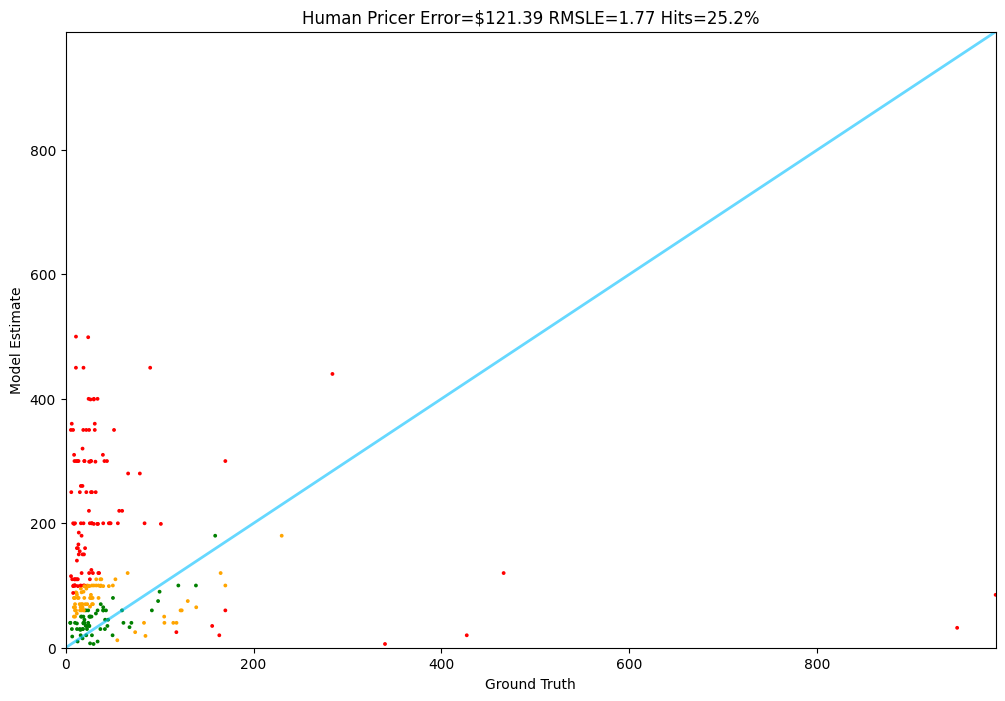

In [10]:
Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [11]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.


# -- original code
# def messages_for(item):
#     system_message = "You estimate prices of items. Reply only with the price, no explanation"
#     user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
#     return [
#         {"role": "system", "content": system_message},
#         {"role": "user", "content": user_prompt},
#         {"role": "assistant", "content": "Price is $"}
#     ]

# -- Gem replacement (Gem doesn't use system prompts)
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        #{"role": "system", "content": system_message},
        {"role": "user", "content": system_message + user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [62]:
# Try this out

print(messages_for(test[2]))

[{'role': 'user', 'content': 'You estimate prices of items. Reply only with the price, no explanationHow much does this cost?\n\nKegco Secondary Regulator, 3 Product, Chrome\nThe Kegco has been designed for applications where you will be reducing the pressure off your primary regulator to dispense three kegs at different pressures To use this secondary regulator, you will still need a primary regulator with one output that connects to the secondary with a piece of air line Boasts three stylish black pressure gauges with high-contrast red and white writing and sturdy rubber boots that help protect them from damage Durable chrome-plated brass body has three gauges and three 5/16 barbs for dispensing three kegs of beer or kombucha at a time Features manual pressure release valves and internal pressure relief valves that release pressure at 55-65 PSI to help ensure safety'}, {'role': 'assistant', 'content': 'Price is $'}]


In [13]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [14]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [ ]:
# Above should be good, below is where i have to make changes to get Gem working

In [51]:
# Initialize and constants

load_dotenv(override=True)
api_key = os.getenv('OPENAI_API_KEY')

if api_key and api_key.startswith('sk-proj-') and len(api_key)>10:
    print("API key looks good so far")
else:
    print("There might be a problem with your API key? Please visit the troubleshooting notebook!")
    
# ----- Replacing with Gem code -----
import os
import google.generativeai as genai
genai.configure(api_key= api_key)

# Create the model
generation_config = {
  "temperature": 0,
  "top_p": 0.95,
  "top_k": 10,
  #"max_output_tokens": 8192,
  "max_output_tokens": 5,
  "response_mime_type": "text/plain",
  #"response_mime_type": "application/json",
}

model = genai.GenerativeModel(model_name="gemini-1.5-flash",
  generation_config=generation_config,)

chat_session = model.start_chat(
  history=[  ])

message = "this is a test only"
response = chat_session.send_message(message)
print(response.text)

There might be a problem with your API key? Please visit the troubleshooting notebook!


Understood.  I'


In [ ]:
# Testing above - using my code to pass single value
y = "Panda Small Portable Washing Machine, 1.54 cu.ft, 8 Wash Programs, Top Load Clothes Washer"
#message = "Where did pizza originate from?"
message = f"""You estimate prices of items. Reply only with the price, no explanation. Here is the item;  
{y}""" # Gray = $261.27
response = chat_session.send_message(message)
print(response.text)

$299



In [ ]:
# Testing above - using my code to pass a list of values
items = [
    "Panda Small Portable Washing Machine, 1.54 cu.ft, 8 Wash Programs, Top Load Clothes Washer",
    "Samsung 5.0 cu.ft High-Efficiency Smart Front Load Washer",
    "LG 4.5 cu.ft Smart Wi-Fi Enabled Washer with TurboWash"
    # Add more items as needed
]

for item in items:
    message = f"""You estimate prices of items. Reply only with the price, no explanation. Here is the item;
    {item}"""
    
    response = chat_session.send_message(message)
    print({item}, response.text)

{'Panda Small Portable Washing Machine, 1.54 cu.ft, 8 Wash Programs, Top Load Clothes Washer'} $300

{'Samsung 5.0 cu.ft High-Efficiency Smart Front Load Washer'} $1300
{'LG 4.5 cu.ft Smart Wi-Fi Enabled Washer with TurboWash'} $1050


In [ ]:

# Below is a mix of Ed code & mine.

In [82]:
# def messages_for(item):
#     system_message = "You estimate prices of items. Reply only with the price, no explanation"
#     user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
#     return [
#         #{"role": "system", "content": system_message},
#         {"role": "user", "content": system_message + user_prompt},
#         {"role": "assistant", "content": "Price is $"}
#     ]

for te in test:
    te.replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    print(te)


AttributeError: 'Item' object has no attribute 'replace'

In [71]:
testy = test[0:10]
testy

[<Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only = $65.99>,
 <TUAIC Refrigerator Door Light Switch 2 Feet for GE Whirlpool, Maytag, Admiral, Amana, Crosley, Jenn-Air, Kenmore, KitchenAid, Magic Chef = $9.68>,
 <Kegco Secondary Regulator, 3 Product, Chrome = $155.98>,
 <MHY62044106 Refrigerator Door Spring 2Pcs Compatible With LG Electronics LFC25765ST MHY62044106 LFX28968SB LMX31985ST LFX28968ST LFX25978SB LFX31945ST = $5.59>,
 <Ice-O-Matic 9131111-01 Float Valve = $98.4>,
 <Wireless Temperature & Humidity Bluetooth Smart Sensor for iPhone/Android - Thermometer/Hygrometer to Monitor Climate for Your Home, Refrigerator, Humidor, Reptiles, Baby, Guitar (Black, 2 Sensors) = $54.99>,
 <3Inch Thermometer Hygrometer for Indoor Outdoor, Mini Portable Patio Home Office Temperature Humidity Meter = $5.71>,
 <GE WH1X2754 GE Timer Knob Assembly,white = $9.53>,
 <newlifeapp 33001003 Dryer Lint Screen Filter. Replacement For Whirlpool & Maytag Dry

In [72]:
# -- Gem replacement (Gem doesn't use system prompts)
def messages_for(item):
    user_prompt = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return user_prompt
    # return [
    #     #{"role": "system", "content": system_message},
    #     {"role": "user", "content": user_prompt},
    #     {"role": "assistant", "content": "Price is $"}
    # ]
#message = messages_for(test[0])
message = messages_for(testy)
response = chat_session.send_message(message)
print(response.text)

AttributeError: 'list' object has no attribute 'test_prompt'

# Expanding on the above...
items = [
    "Panda Small Portable Washing Machine, 1.54 cu.ft, 8 Wash Programs, Top Load Clothes Washer",
    "Samsung 5.0 cu.ft High-Efficiency Smart Front Load Washer",
    "LG 4.5 cu.ft Smart Wi-Fi Enabled Washer with TurboWash"
    # Add more items as needed
]

for item in items:
    message = f"""You estimate prices of items. Reply only with the price, no explanation. Here is the item;
    {item}"""
    
    response = chat_session.send_message(message)
    print(response.text)

In [53]:
# The function for gpt-4o-mini
# -- Original code
# def gpt_4o_mini(item):
#     response = openai.chat.completions.create(
#         model="gpt-4o-mini", 
#         messages=messages_for(item),
#         seed=42,
#         max_tokens=5    )
#     reply = response.choices[0].message.content
#     return get_price(reply)


# -- Need to replace with Gem
def gpt_4o_mini(item):
    #response = chat_session.send_message(messages_for(item)) 
    response = chat_session.send_message(item) 
    #reply = response.choices[0].message.content
    reply = response.text
    print (reply)
    return get_price(reply)

In [42]:
#item = "The does a price of roughly $99.99 for a donut sound about right?"
y = "Panda Small Portable Washing Machine, 1.54 cu.ft, 8 Wash Programs, Top Load Clothes Washer"
item = """You estimate prices of items. Reply only with the price, no explanation. Here is the item; {y} """ 
print(gpt_4o_mini(item))

$0

0.0


In [59]:
print(train[0])
print(test[0].price)

<WB31T10010 and WB31T10011 Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces) = $11.99>
65.99


In [27]:
Tester.test(gpt_4o_mini, test)

KeyError: "Unable to determine the intended type of the `dict`. For `Content`, a 'parts' key is expected. For `Part`, either an 'inline_data' or a 'text' key is expected. For `Blob`, both 'mime_type' and 'data' keys are expected. However, the provided dictionary has the following keys: ['role', 'content']"

In [ ]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [ ]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

In [ ]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

In [ ]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(claude_3_point_5_sonnet, test)